### Kelly criterion and position sizing

reference : Hudson theme - working papers

#### Data import

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
data_train = pd.read_csv('train.csv', index_col = 0, parse_dates = True)
data_test = pd.read_csv('test.csv', index_col = 0, parse_dates = True)

data_train.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
1996-09-16,0.017992,0,0.0,-0.011306,1,0.000000,-0.001710,-0.024446,0.0,0,0.483883,0.359934,0
1996-09-17,-0.011306,0,0.0,-0.023230,0,-0.011306,0.017992,-0.001710,0.0,0,0.000000,0.000000,0
1996-09-18,-0.023230,0,1.0,0.003880,0,-0.000000,-0.011306,0.017992,0.0,0,0.000000,0.000000,0
1996-09-19,0.003880,0,1.0,0.017922,1,0.000000,-0.023230,-0.011306,0.0,1,0.539161,0.506199,1
1996-09-20,0.017922,0,0.0,-0.011900,1,0.017922,0.003880,-0.023230,0.0,0,0.480208,0.351600,0


p model에서 label이 1인 것들만 filtering하여 prob의 histogram을 살펴보자

In [3]:
data = data_train[data_train['pmodel'] == 1]

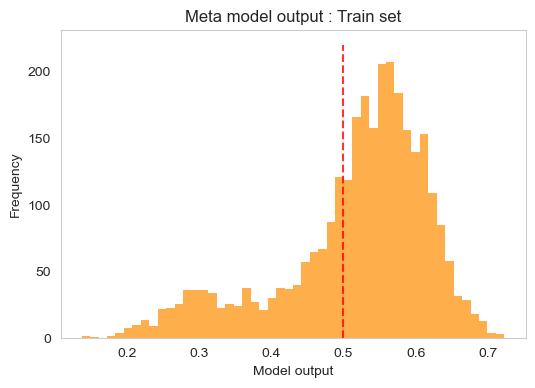

In [4]:
plt.figure(figsize = (6, 4))
plt.hist(data['prob'], color = 'darkorange', alpha = 0.7, bins = 50, edgecolor = 'none')
plt.title('Meta model output : Train set')
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 220, colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

기대되는 win & loss의 값을 구한다

In [5]:
true_pos = data[(data['pred'] == 1) & (data['target'] == 1)]
false_pos = data[(data['pred'] == 1) & (data['target'] == 0)]

exp_gain = true_pos['target_rets'].mean()
exp_loss = false_pos['target_rets'].mean()

print(f'E[gain] : {np.round(exp_gain, 3)}')
print(f'E[loss] : {np.round(exp_loss, 3)}')

E[gain] : 0.014
E[loss] : -0.012


kelly criterion 함수를 정의한다

In [6]:
def kelly(p, win, loss) : return (p / abs(loss)) - ((1 - p) / win)

포지션 사이즈를 계산하여, kelly 기준을 이용한 포저션의 prob을 histogram으로 시각화한다

In [7]:
b = kelly(p = data['prob'], win = exp_gain, loss = exp_loss)

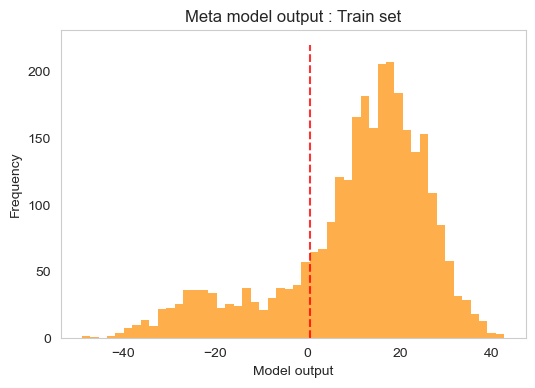

Max level : 42.69


In [8]:
plt.figure(figsize = (6, 4))
plt.hist(b, color = 'darkorange', alpha = 0.7, bins = 50, edgecolor = 'none')
plt.title('Meta model output : Train set')
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 220, colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

print(f'Max level : {np.round(b.max(), 2)}')

In [9]:
kelly(p = 0.468, win = 0.014, loss = 0.012)

1.0

p = 0.468일 때, 모든 포지션 사이즈가 1로 점핑한다. 따라서 prob이 0.5 이상일 때 1의 포지션 크기를 잡는 것은 유용하지 못하다

#### Frequentist analog

빈도주의 확률로 베이시안 확률을 매핑할 수 있는지 알아보자

- manual mapping(수동적 매핑)
- model calibration(확률 보정)
- lit review(문헌 리뷰)

십분위로 분할하여 넣고, 그 분할된 수가 얼마나 자주 발생하는지 확인한다

In [10]:
data['cat'], b, = pd.qcut(data['prob'], q = 10, retbins = True) # 10분위수로 cutting

10분위수당 확률을 계산하여 plotting한다

In [11]:
acc = data.groupby(['cat', 'target']).count()['prob'].unstack()
accuracy = acc[1] / acc.sum(axis = 1)

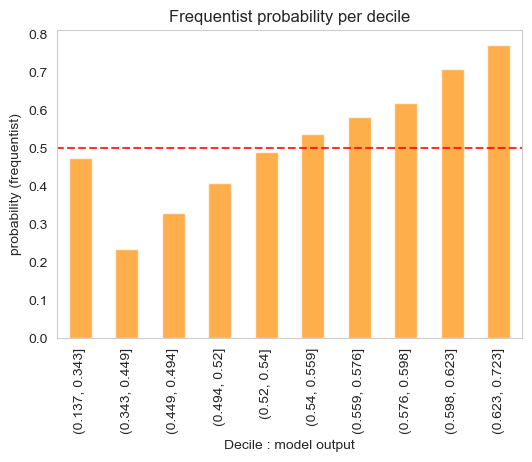

In [12]:
accuracy.plot.bar(figsize = (6, 4), color = 'darkorange', alpha = 0.7)
plt.title('Frequentist probability per decile')
plt.xlabel('Decile : model output')
plt.ylabel('probability (frequentist)')
plt.grid(False)
plt.hlines(y = 0.5, xmin = -1, xmax = accuracy.shape[0], colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

kelly criterion은 매우 민감하다. p > 0.467이라면 결과값이 1 이상이 된다

In [13]:
kelly(p = 0.467, win = exp_gain, loss = exp_loss)

2.592665016655289

참고: 각 10분위마다 예상되는 win / loss가 있다

In [14]:
exp_wins = data[data['target_rets'] > 0].groupby(['cat'])['target_rets'].mean()
exp_losses = data[data['target_rets'] < 0].groupby(['cat'])['target_rets'].mean()

In [15]:
exp_wins

cat
(0.137, 0.343]    0.013399
(0.343, 0.449]    0.012302
(0.449, 0.494]    0.010421
(0.494, 0.52]     0.010687
(0.52, 0.54]      0.011665
(0.54, 0.559]     0.014559
(0.559, 0.576]    0.012745
(0.576, 0.598]    0.014608
(0.598, 0.623]    0.014433
(0.623, 0.723]    0.017117
Name: target_rets, dtype: float64

In [16]:
pstore, sstore = [], []
for i in range(0, 10):
    indx = i
    b = kelly(accuracy.iloc[indx], exp_wins.iloc[indx], exp_losses.iloc[indx])
    p = np.round(accuracy.iloc[indx], 3)
    print(f'Probability : {p : .3f} \twin : {np.round(exp_wins.iloc[indx], 3) : .3f} \tloss : {np.round(exp_losses.iloc[indx], 3) : .3f}')
    scaled = np.round(np.min([np.max([b, 0]), 1]), 2)
    print(f'Size : {np.round(b, 2)} \tScaled : {scaled}') 
    print('-----------------------------------------------------\n')
    pstore.append(p)
    sstore.append(scaled)

Probability :  0.475 	win :  0.013 	loss : -0.011
Size : 2.49 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.234 	win :  0.012 	loss : -0.018
Size : -49.54 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.329 	win :  0.010 	loss : -0.015
Size : -42.23 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.408 	win :  0.011 	loss : -0.013
Size : -23.77 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.490 	win :  0.012 	loss : -0.013
Size : -5.53 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.538 	win :  0.015 	loss : -0.010
Size : 19.8 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.584 	win :  0.013 	loss : -0.011
Size : 21.5 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.619 	win :  0.015 	loss : -0.011
Size : 27.78 	Scaled : 1.0

각 분위별 포지션 사이즈를 확인해 보자

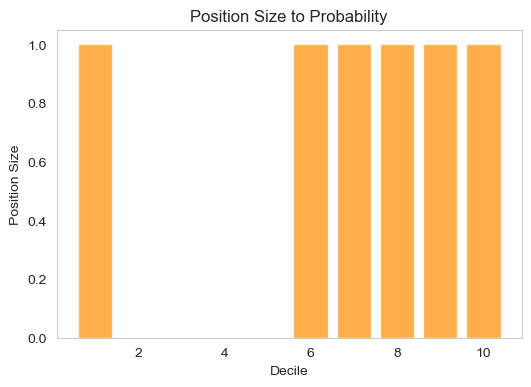

In [17]:
plt.figure(figsize = (6, 4))
plt.bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], sstore, color = 'darkorange', alpha = 0.7)
plt.title('Position Size to Probability')
plt.ylabel('Position Size')
plt.xlabel('Decile')
plt.grid(False)
plt.show()

#### Probability Calibration

다음을 참고하자 : 
- https://towardsdatascience.com/calibrating-classifiers-559abc30711a

In [18]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [19]:
bins = 10
print(f"Min : {np.round(data['prob'].min(), 2)} \t Max : {np.round(data['prob'].max(), 2)}\n")

Min : 0.14 	 Max : 0.72


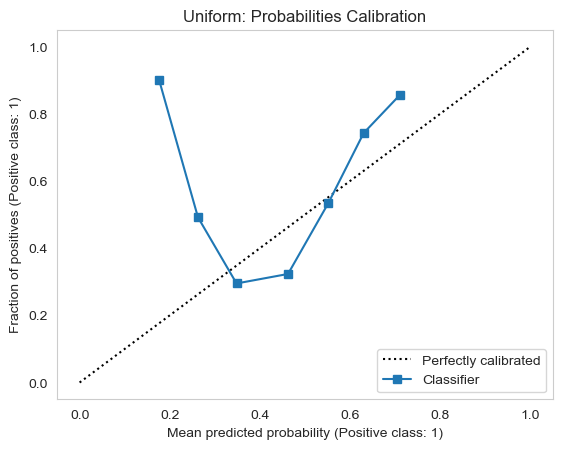

In [20]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_true = data['target'], y_prob = data['prob'], n_bins = bins, strategy = 'uniform', ax = ax)
plt.grid(False)
plt.title('Uniform: Probabilities Calibration')
plt.show()

Text(0.5, 1.0, 'Quantile: Probabilities Calibration')

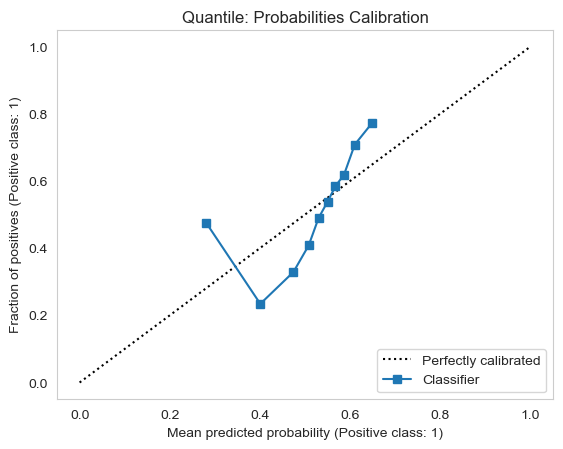

In [21]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_true = data['target'], y_prob = data['prob'], n_bins = bins, strategy = 'quantile', ax = ax)
plt.grid(False)
plt.title('Quantile: Probabilities Calibration')

많은 모형이 특히 매우 낮고 높은 값에 대해 편향된 확률 추정치를 추정하는 이유는 무엇일까?

- 작동 방식에 따라 모델마다 이유가 조금씩 다르다
- Naive Bayes, SVM 또는 Decision Tree와 같은 많은 다른 분류 모델도 S자형 calibration curve를 생성할 것이다
- **이에 대한 일반적인 이유는 대부분의 분류 모델이 binary metric에 대해 최적화되고 scoring되기 때문이다**

**주의**

Logistic Regression은 실제로 보정 확률을 생성하는 것으로 알려져 있지만, 이는 모델이 훈련 데이터에 과적합되지 않도록 하기 위해 규제를 사용할 때만 해당된다. 앞으로 나올 내용들은 실제 모델 비용 기능을 최적화한다. 이는 모델 비용 기능을 최적화한다

**접근 방법**

- Platt-scaling (Sigital)

- Isotonic Regression (Non-parametric)
    - bias의 양상을 보정하지만, overfit의 위험이 있다
    - 이 연습에서는 Platt-scaling을 추천하지만, 만약 데이터의 크기가 커진다면 잘 작동하지 않을 수도 있다.

Calibration Model은 Random Forest가 적합했던 것보다 다른 데이터를 기반으로 해야 한다. 따라서 별도의 validation data set을 필요로 한다. 혹은, Cross-validation을 통해 보정 모델을 훈련시킬 수도 있다. 이 과정에서는 ```CalibratedClassifierCV```를 사용한다

#### Calibration Conclusion

Random Forest, Decision Tree, Support Vector Machine 또는 Naive Bayes와 같은 많은 Classification model은 class membership의 편향된 확률 추정치를 반환한다. 이러한 편향된 확률은 threshold를 지정하는 데 사용할 수 있지만 certainty measure로 사용하기는 어렵다. 예를 들어, 이러한 모형에 따르면 한 표본이 어떤 집단에 속할 확률이 70%이고 다른 표본이 50%라면 전자는 실제로 이 집단에 속할 확률이 더 높지만 실제로는 그렇지 않을 확률이 70%에 달한다.

이 현상은 확률 추정치가 극단치에 가까울수록 더 심한데, 한 예로 모델이 2%를 예측하면 실제 확률은 이보다 더 높을 가능성이 있고 97%를 예측하면 일반적으로 더 낮을 가능성이 높다. 이렇게 편향된 확률을 수정하는 과정을 `Calibration`이라고 한다. 이는 초기 모델 위에 Calibration Model을 훈련시키는 것으로 할 수 있다. 자주 사용되는 두 가지 Calibration model은 logistic과 isotonic regression이다

Calibration model을 Training하려면 과적합을 방지하기 위해 별도의 validation data set를 갖거나 cross validation을 수행해야 한다. 이 과정은 모두 sklearn library에서 실행 가능하다.

#### Test Calibration algorithms

CalibrationClassifierCV를 사용하여 calibration model을 훈련시키고, 이를 통해 확률을 보정한다. 이 과정에서는 ```CalibratedClassifierCV```를 사용한다.

In [22]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
X_train_regime = data_train[['rets','rets2','rets3','regime']][data_train['pmodel'] == 1]
X_test_regime = data_test[['rets','rets2','rets3','regime']][data_test['pmodel'] == 1]
y_train_regime = data_train['target'][data_train['pmodel'] == 1]
y_test_regime = data_test['target'][data_test['pmodel'] == 1]

In [24]:
scalar = StandardScaler()
X_train_regime_scaled = scalar.fit_transform(X_train_regime)
X_test_regime_scaled = scalar.transform(X_test_regime)

Train Model (FP)

In [25]:
meta_model_regime = LogisticRegression(random_state = 42, penalty = None)
meta_model_regime.fit(X_train_regime_scaled, y_train_regime)

LogisticRegression(penalty=None, random_state=42)

calibration model을 적용한다

In [26]:
calibrated_model_sigmoid = CalibratedClassifierCV(estimator = meta_model_regime, method = 'sigmoid', cv = 5, n_jobs = -1)
calibrated_model_sigmoid.fit(X_train_regime_scaled, y_train_regime)

calibrated_model_isotonic = CalibratedClassifierCV(estimator = meta_model_regime, method = 'isotonic', cv = 5, n_jobs = -1)
calibrated_model_isotonic.fit(X_train_regime_scaled, y_train_regime)

probs_sigmoid = calibrated_model_sigmoid.predict_proba(X_train_regime_scaled)[:, 1]
probs_isotonic = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]

In [27]:
calibrated_model_sigmoid = CalibratedClassifierCV(base_estimator=meta_model_regime, method='sigmoid', cv=5, n_jobs=-1)
calibrated_model_sigmoid.fit(X_train_regime_scaled, y_train_regime)

calibrated_model_isotonic = CalibratedClassifierCV(base_estimator=meta_model_regime, method='isotonic', cv=5, n_jobs=-1)
calibrated_model_isotonic.fit(X_train_regime_scaled, y_train_regime)

CalibratedClassifierCV(base_estimator=LogisticRegression(penalty=None,
                                                         random_state=42),
                       cv=5, method='isotonic', n_jobs=-1)

calibration model로부터 확률을 추정한다

In [28]:
probs_sigmoid = calibrated_model_sigmoid.predict_proba(X_train_regime_scaled)[:, 1]
probs_isotonic = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]

Get iso model scores

In [29]:
probs_isotonic = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]

Get base model scores

In [30]:
base_scores = np.array([cmodel.estimator.predict_proba(X_train_regime_scaled)[:, 1]
                        for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis=0)


Check that the base model and calibrated models align

In [31]:
assert (base_scores.shape == probs_isotonic.shape) # validation

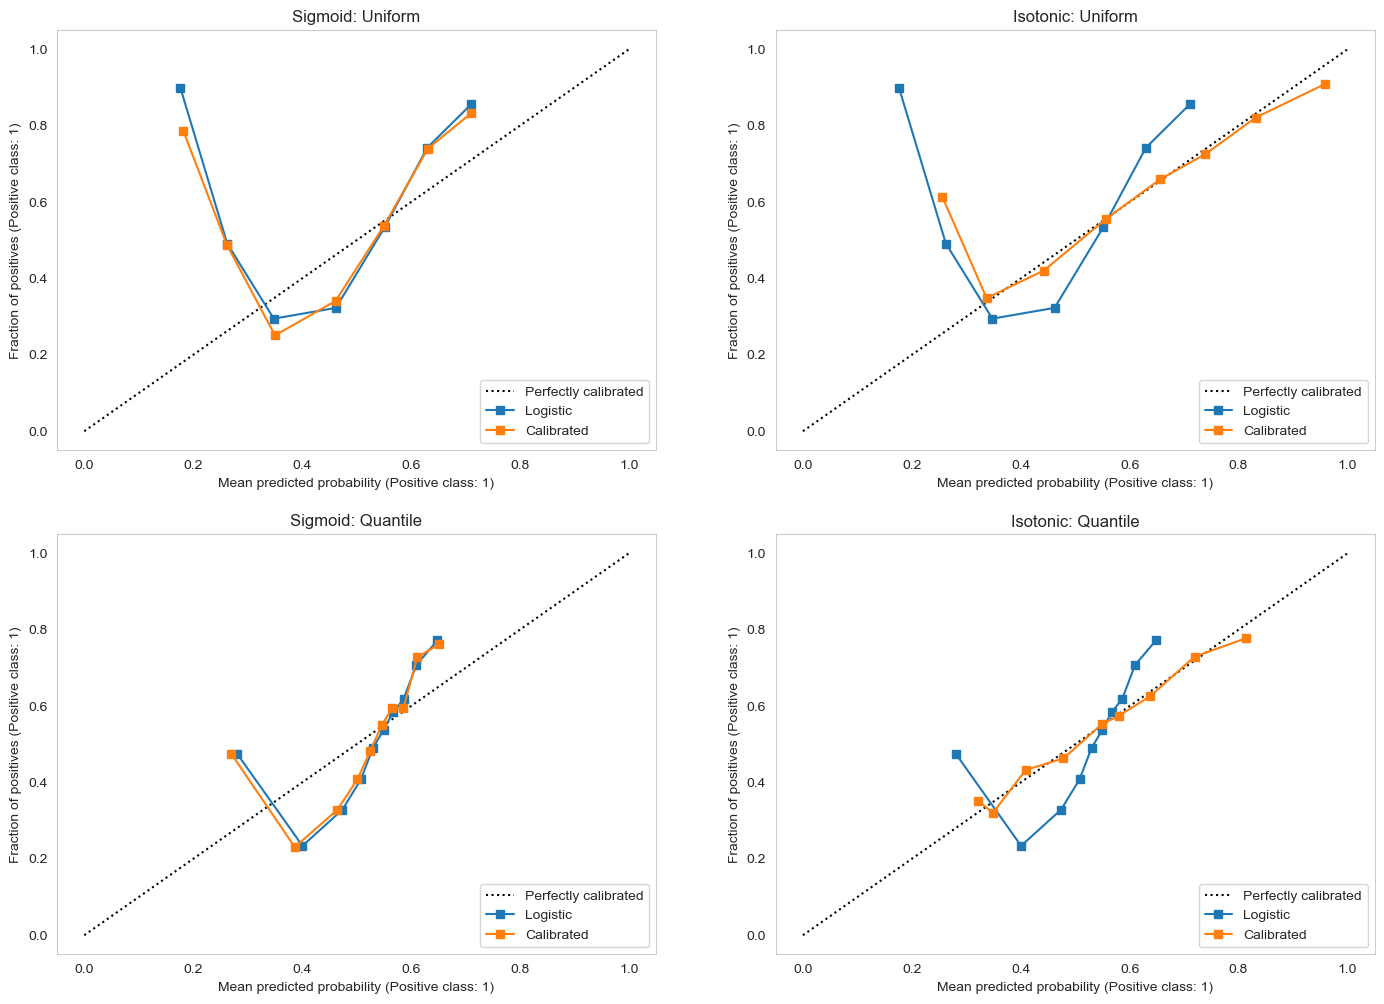

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(17, 12))

# 1st
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob'], ax=axs[0, 0], n_bins=bins, strategy='uniform')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_sigmoid, ax=axs[0, 0], n_bins=bins, strategy='uniform')
axs[0, 0].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[0, 0].grid(False)
axs[0, 0].set_title('Sigmoid: Uniform')

# 2nd
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob'], ax=axs[1, 0], n_bins=bins, strategy='quantile')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_sigmoid, ax=axs[1, 0], n_bins=bins, strategy='quantile')
axs[1, 0].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[1, 0].grid(False)
axs[1, 0].set_title('Sigmoid: Quantile')

# 3rd
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob'], ax=axs[0, 1], n_bins=bins, strategy='uniform')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_isotonic, ax=axs[0, 1], n_bins=bins, strategy='uniform')
axs[0, 1].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[0, 1].grid(False)
axs[0, 1].set_title('Isotonic: Uniform')

# 4th
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob'], ax=axs[1, 1], n_bins=bins, strategy='quantile')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_isotonic, ax=axs[1, 1], n_bins=bins, strategy='quantile')
axs[1, 1].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[1, 1].grid(False)
axs[1, 1].set_title('Isotonic: Quantile')

plt.show()

In [33]:
data['probs_isotonic'] = probs_isotonic
data.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso,cat,probs_isotonic
1996-09-16,0.017992,0,0.0,-0.011306,1,0.000000,-0.001710,-0.024446,0.0,0,0.483883,0.359934,0,"(0.449, 0.494]",0.359934
1996-09-19,0.003880,0,1.0,0.017922,1,0.000000,-0.023230,-0.011306,0.0,1,0.539161,0.506199,1,"(0.52, 0.54]",0.506230
1996-09-20,0.017922,0,0.0,-0.011900,1,0.017922,0.003880,-0.023230,0.0,0,0.480208,0.351600,0,"(0.449, 0.494]",0.351600
1996-09-23,0.016120,0,0.0,-0.004664,1,0.000000,-0.006262,-0.011900,0.0,1,0.533467,0.502675,1,"(0.52, 0.54]",0.502675
1996-09-26,0.001643,0,0.0,-0.021602,1,0.000000,-0.006364,-0.004664,0.0,1,0.535604,0.496829,0,"(0.52, 0.54]",0.496829


Position size를 계산한다

In [34]:
b = kelly(p = data['prob'], win = exp_gain, loss = exp_loss)
c = kelly(p = data['probs_isotonic'], win = exp_gain, loss = exp_loss)

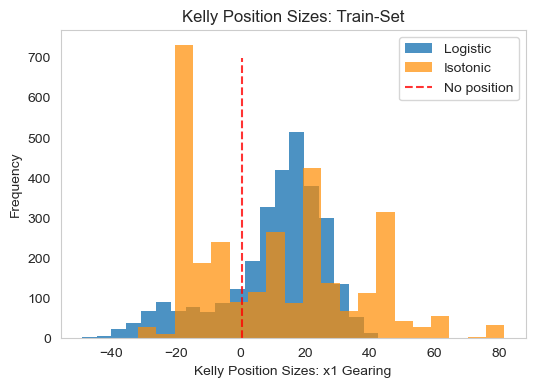

In [35]:
plt.figure(figsize = (6, 4))
plt.hist(b, alpha = 0.8, bins = 20, label = 'Logistic', edgecolor = 'none')
plt.hist(c, color = 'darkorange', alpha = 0.7, bins = 20, label = 'Isotonic', edgecolor = 'none')
plt.title('Kelly Position Sizes: Train-Set')
plt.xlabel('Kelly Position Sizes: x1 Gearing')
plt.ylabel('Frequency')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 700, colors = 'red', linestyles = '--', alpha = 0.8, label = 'No position')
plt.legend()
plt.show()

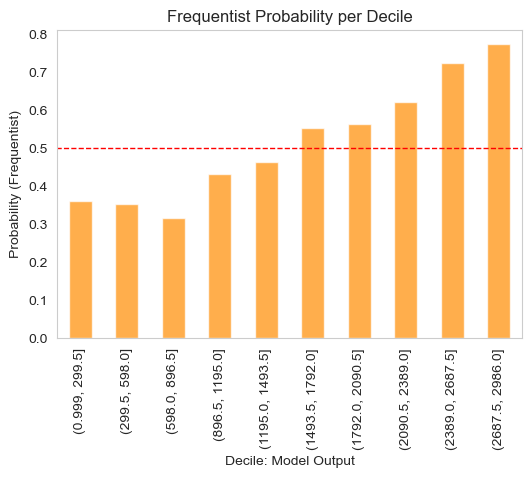

In [36]:
data['cat_iso'], _, = pd.qcut(data['probs_isotonic'].rank(method = 'first'), q = 10, retbins=True)

# Compute probability per decile
acc = data.groupby(['cat_iso', 'target']).count()['probs_isotonic'].unstack()
accuracy_iso = acc[1] / acc.sum(axis=1)

# Plot probability of true, per decile
accuracy_iso.plot.bar(figsize = (6, 4), grid = False, color = 'darkorange', alpha = 0.7)
plt.title('Frequentist Probability per Decile')
plt.xlabel('Decile: Model Output')
plt.ylabel('Probability (Frequentist)')
plt.hlines(
    y = 0.5, xmin = -1, xmax = accuracy_iso.shape[0], 
    colors = 'red', linestyles = '--', linewidth = 1
)
plt.show()

In [37]:
exp_wins_i = data[data['target_rets'] > 0].groupby(['cat_iso'])['target_rets'].mean()
exp_losses_i = data[data['target_rets'] < 0].groupby(['cat_iso'])['target_rets'].mean()

In [38]:
pstorei, sstorei = [], []
for i in range(0, 10):
    indx = i
    b = kelly(accuracy.iloc[indx], exp_wins.iloc[indx], exp_losses.iloc[indx])
    bi = kelly(accuracy_iso.iloc[indx], exp_wins.iloc[indx], exp_losses.iloc[indx])
    p = np.round(accuracy.iloc[indx], 3)
    pi = np.round(accuracy_iso.iloc[indx], 3)
    print(f'Prob : {p : .3f} \tProb_iso : {pi : .3f} '
          f'\twin : {np.round(exp_wins.iloc[indx], 3) : .3f} '
          f'\tloss : {np.round(exp_losses.iloc[indx], 3) : .3f}')
    scaled = np.round(np.min([np.max([b, 0]), 1]), 2)
    print(f'Size : {np.round(b, 2)} \tScaled : {scaled}') 
    print('-----------------------------------------------------------------\n')
    pstorei.append(p)
    sstorei.append(scaled)

Prob :  0.475 	Prob_iso :  0.361 	win :  0.013 	loss : -0.011
Size : 2.49 	Scaled : 1.0
-----------------------------------------------------------------

Prob :  0.234 	Prob_iso :  0.351 	win :  0.012 	loss : -0.018
Size : -49.54 	Scaled : 0.0
-----------------------------------------------------------------

Prob :  0.329 	Prob_iso :  0.315 	win :  0.010 	loss : -0.015
Size : -42.23 	Scaled : 0.0
-----------------------------------------------------------------

Prob :  0.408 	Prob_iso :  0.431 	win :  0.011 	loss : -0.013
Size : -23.77 	Scaled : 0.0
-----------------------------------------------------------------

Prob :  0.490 	Prob_iso :  0.463 	win :  0.012 	loss : -0.013
Size : -5.53 	Scaled : 0.0
-----------------------------------------------------------------

Prob :  0.538 	Prob_iso :  0.552 	win :  0.015 	loss : -0.010
Size : 19.8 	Scaled : 1.0
-----------------------------------------------------------------

Prob :  0.584 	Prob_iso :  0.564 	win :  0.013 	loss : -0.011
S

각 분위별 포지션 사이즈를 확인해 보자

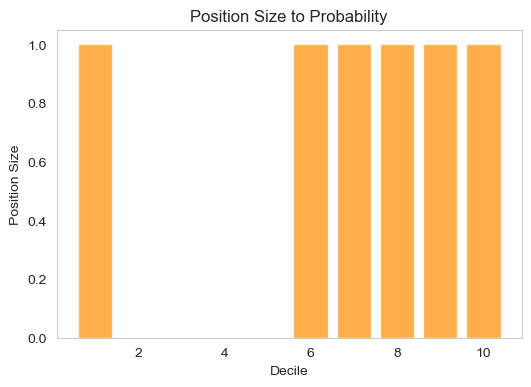

In [39]:
plt.figure(figsize = (6, 4))
plt.bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], sstorei, color = 'darkorange', alpha = 0.7)
plt.title('Position Size to Probability')
plt.ylabel('Position Size')
plt.xlabel('Decile')
plt.grid(False)
plt.show()

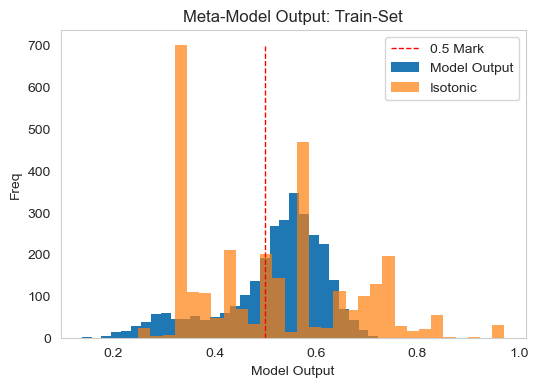

In [40]:
plt.figure(figsize = (6, 4))
data['prob'].hist(bins = 30, edgecolor = 'none')
data['probs_isotonic'].hist(alpha = 0.7, bins = 30, edgecolor = 'none')
plt.title('Meta-Model Output: Train-Set')
plt.xlabel('Model Output')
plt.ylabel('Freq')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 700, colors = 'red', linestyles = '--', linewidth = 1)
plt.legend(['0.5 Mark', 'Model Output', 'Isotonic'])
plt.show()

#### Position Sizing

In [41]:
prob = data['prob']
prob_iso = data['probs_isotonic']

target_return_train = data['target_rets']

**Meta labeling on Probabilities**

Daily data update with position sizes

In [42]:
data_train['meta_bet_size'] = 0
data_train['meta_bet_size_iso'] = 0
data_train.loc[data.index, 'meta_bet_size'] = prob
data_train.loc[data.index, 'meta_bet_size_iso'] = prob_iso

Backtesting

In [43]:
data_train['meta_rets'] = (data_train['meta_bet_size'] * data_train['target_rets']).shift(1)
data_train['meta_iso_rets'] = (data_train['meta_bet_size_iso'] * data_train['target_rets']).shift(1)

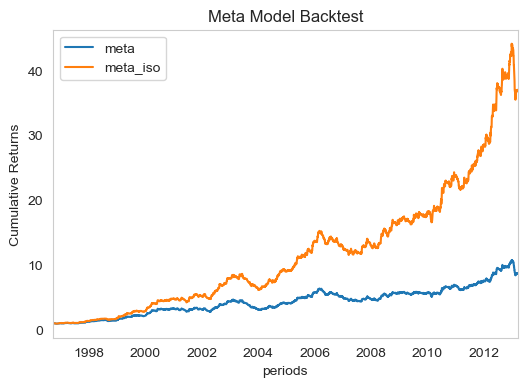

In [44]:
plt.figure(figsize = (6, 4))
(data_train['meta_rets'] + 1).cumprod().plot()
(data_train['meta_iso_rets'] + 1).cumprod().plot()
plt.legend(['meta', 'meta_iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

**Linear Dependency Models**

In [45]:
def linear_scaling(prob_train, prob_test):
    bet_sizes = (prob_test - prob_train.min()) / (prob_train.max() - prob_train.min())
    return bet_sizes

Linear betting sizes

In [46]:
bet_sizes_meta = linear_scaling(prob, prob)
bet_sizes_iso = linear_scaling(prob_iso, prob_iso)

daily data update with position sizes

In [47]:
data_train.loc[data.index, 'lin_bet_size_iso'] = bet_sizes_iso
data_train.loc[data.index, 'lin_bet_size_meta'] = bet_sizes_meta

Backtesting

In [48]:
data_train['lin_meta_rets'] = (data_train['lin_bet_size_meta'] * data_train['target_rets']).shift(1)
data_train['lin_iso_rets'] = (data_train['lin_bet_size_iso'] * data_train['target_rets']).shift(1)

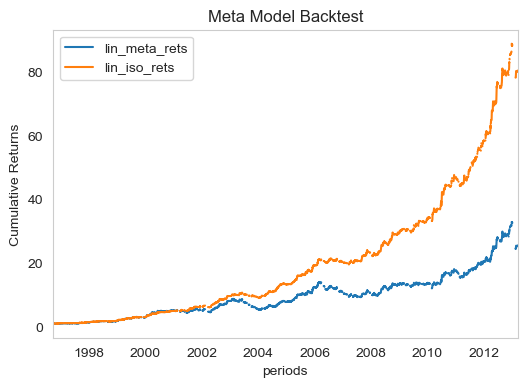

In [49]:
plt.figure(figsize = (6, 4))
(data_train['lin_meta_rets'] + 1).cumprod().plot()
(data_train['lin_iso_rets'] + 1).cumprod().plot()
plt.legend(['lin_meta_rets', 'lin_iso_rets'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

**ECDF(Empirical Distribution Function)**

경험적 누적 분포 함수

In [50]:
from statsmodels.distributions.empirical_distribution import ECDF

In [51]:
ecdf = ECDF(prob)
ecdf_iso = ECDF(prob_iso)

ECDF를 활용해 position size를 계산한다

In [52]:
ecdf_size = prob.apply(lambda x : ecdf(x))
ecdf_size_iso = prob_iso.apply(lambda x : ecdf_iso(x))

daily data update with position sizes

In [53]:
data_train.loc[data.index, 'ecdf_size'] = ecdf_size
data_train.loc[data.index, 'ecdf_size_iso'] = ecdf_size_iso

# Backtest
data_train['ecdf_rets'] = (data_train['ecdf_size'] * data_train['target_rets']).shift(1)
data_train['ecdf_iso_rets'] = (data_train['ecdf_size_iso'] * data_train['target_rets']).shift(1)
# data_train.dropna(inplace=True)

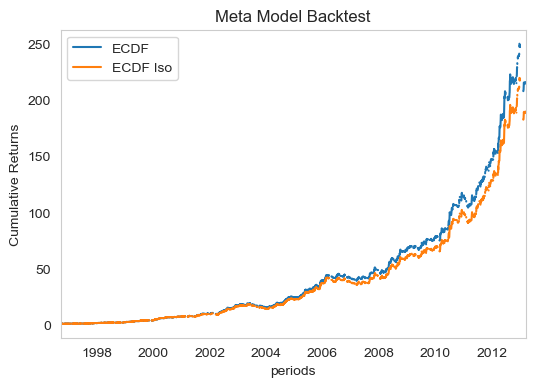

In [55]:
plt.figure(figsize = (6, 4))
(data_train['ecdf_rets'] + 1).cumprod().plot()
(data_train['ecdf_iso_rets'] + 1).cumprod().plot()
plt.legend(['ECDF', 'ECDF Iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

매우 커지는 것을 알 수 있다

**Lopez de prado sizing**

In [56]:
from scipy.stats import norm
from FinancialMachineLearning.bet_sizing.bet_sizing import de_prado_bet_size

In [57]:
dp_size = de_prado_bet_size(prob, clip = True)
dp_size_iso = de_prado_bet_size(prob_iso, clip = True)

In [58]:
data_train.loc[data.index, 'dp_size'] = dp_size
data_train.loc[data.index, 'dp_size_iso'] = dp_size_iso

In [59]:
data_train['dp_rets'] = (data_train['dp_size'] * data_train['target_rets']).shift(1)
data_train['dp_rets_iso'] = (data_train['dp_size_iso'] * data_train['target_rets']).shift(1)

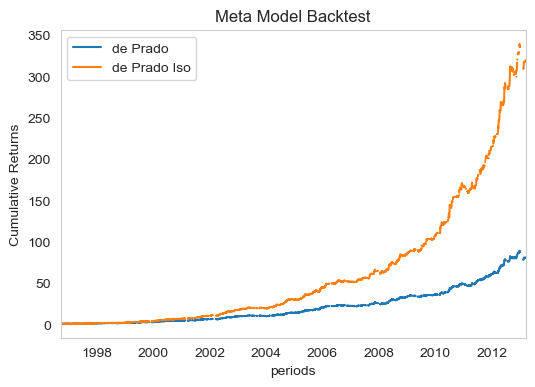

In [60]:
plt.figure(figsize = (6, 4))
(data_train['dp_rets'] + 1).cumprod().plot()
(data_train['dp_rets_iso'] + 1).cumprod().plot()
plt.legend(['de Prado', 'de Prado Iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

**Sigmoid optimal fitting**

In [61]:
from scipy.optimize import minimize

def target(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    
    # Backtest + sharpe ratio
    rets = f(prob) * target_return_train
    sharp_ratio = np.mean(rets) / np.std(rets)
    return - sharp_ratio

def target_iso(x):
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    values = f(prob_iso) * target_return_train
    return - np.mean(values) / np.std(values)

In [62]:
x0 = np.array([1, 0])
res = minimize(target, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': False})
model = res.x
scaled = 1 / (1 + np.exp(-model[0] * prob - model[1]))

x0 = np.array([1, 0])
res = minimize(target_iso, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': False})
model = res.x
scaled_iso = 1 / (1 + np.exp(-model[0] * prob_iso - model[1]))

In [63]:
# Assign position sizes
data_train.loc[data.index, 'sop_size'] = scaled
data_train.loc[data.index, 'sop_size_iso'] = scaled_iso

# Get daily rets
data_train['sop_rets'] = (data_train['sop_size'] * data_train['target_rets']).shift(1)
data_train['sop_rets_iso'] = (data_train['sop_size_iso'] * data_train['target_rets']).shift(1)

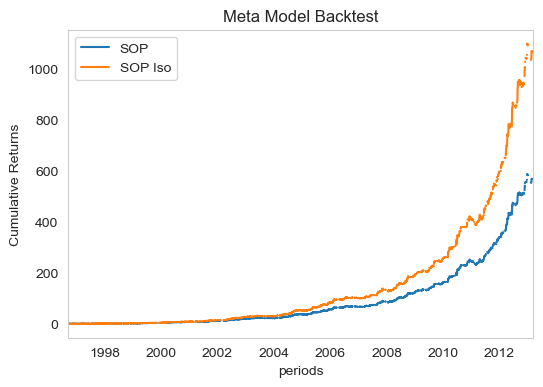

In [65]:
plt.figure(figsize = (6, 4))
(data_train['sop_rets'] + 1).cumprod().plot()
(data_train['sop_rets_iso'] + 1).cumprod().plot()
plt.legend(['SOP', 'SOP Iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

**Optimal Linear**

In [66]:
def target_linear(x):
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    
    rets = f(prob) * target_return_train
    if np.std(rets) == 0.0:
        stdev = 1000
    else: 
        stdev = np.std(rets)
    sr = np.mean(rets) / stdev
    return -sr

def target_linear_iso(x):

    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    
    rets = f(prob_iso) * target_return_train
    if np.std(rets) == 0.0:
        stdev = 1000
    else: 
        stdev = np.std(rets)
    sr = np.mean(rets) / stdev
    return -sr

In [67]:
x0 = np.array([1, 0])
res = minimize(target_linear, x0, method = 'nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
model = res.x
lops_size = model[0] * prob + model[1]

# Clip
lops_size[lops_size > 1] = 1
lops_size[lops_size < 0] = 0

x0 = np.array([1, 0])
res = minimize(target_linear_iso, x0, method = 'nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
model = res.x
lops_size_iso = model[0] * prob_iso + model[1]

# Clip
lops_size_iso[lops_size_iso > 1] = 1
lops_size_iso[lops_size_iso < 0] = 0

In [68]:
# Assign position sizes
data_train.loc[data.index, 'lops_size'] = lops_size
data_train.loc[data.index, 'lops_size_iso'] = lops_size_iso

# Get daily rets
data_train['lops_rets'] = (data_train['lops_size'] * data_train['target_rets']).shift(1)
data_train['lops_rets_iso'] = (data_train['lops_size_iso'] * data_train['target_rets']).shift(1)

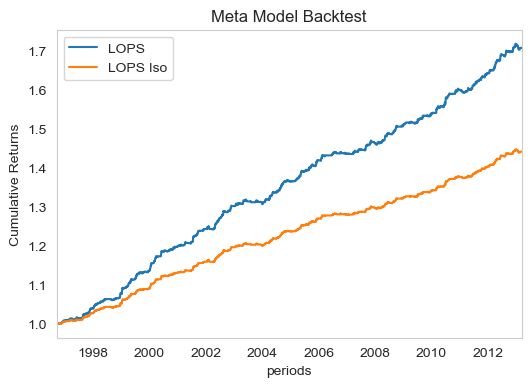

In [69]:
plt.figure(figsize = (6, 4))
(data_train['lops_rets'] + 1).cumprod().plot()
(data_train['lops_rets_iso'] + 1).cumprod().plot()
plt.legend(['LOPS', 'LOPS Iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

**Kelly Criterion**

We also need to calculate b here - expected win ratio

In [73]:
winning_trades = data['target_rets'] > 0
loosing_trades = data['target_rets'] < 0
exp_loss = -data.loc[loosing_trades, 'target_rets'].mean()
exp_win = data.loc[winning_trades, 'target_rets'].mean()

print(exp_loss)
print(exp_win)

0.01316095796222552
0.013672344711758959


In [74]:
def clip_kelly(b):
    return np.min([np.max([b, 0]), 1])

kelly_size = kelly(p = data['prob'], win = exp_win, loss = exp_loss)
kelly_size = kelly_size.apply(clip_kelly)
kelly_size_iso = (prob_iso / exp_loss) + ((prob_iso - 1) / exp_win)
kelly_size_iso = kelly_size_iso.apply(clip_kelly)

In [75]:
# Assign position sizes
data_train.loc[data.index, 'kelly_size'] = kelly_size
data_train.loc[data.index, 'kelly_size_iso'] = kelly_size_iso

# Get daily rets
data_train['kelly_rets'] = (data_train['kelly_size'] * data_train['target_rets']).shift(1)
# Get daily rets
data_train['kelly_rets'] = (data_train['kelly_size'] * data_train['target_rets']).shift(1)
data_train['kelly_rets_iso'] = (data_train['kelly_size_iso'] * data_train['target_rets']).shift(1)

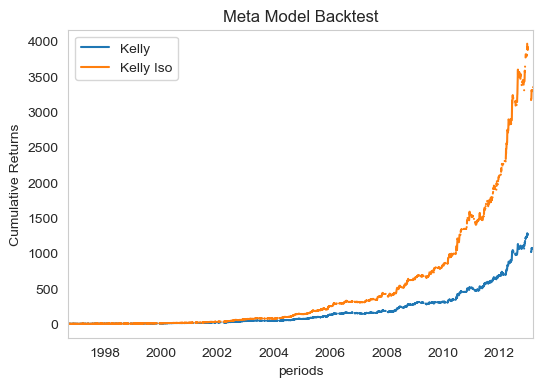

In [76]:
plt.figure(figsize = (6, 4))
(data_train['kelly_rets'] + 1).cumprod().plot()
(data_train['kelly_rets_iso'] + 1).cumprod().plot()
plt.legend(['Kelly', 'Kelly Iso'])
plt.grid(False)
plt.title('Meta Model Backtest')
plt.xlabel('periods')
plt.ylabel('Cumulative Returns')
plt.show()

#### Final Results

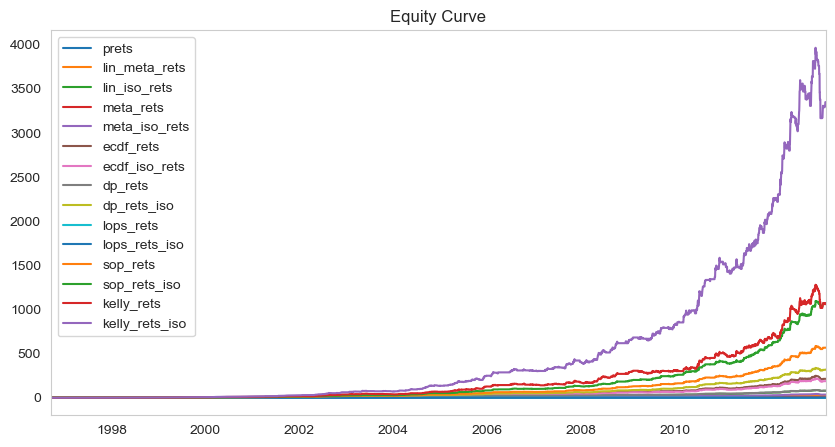

In [81]:
ret_names = ['prets',
             'lin_meta_rets', 'lin_iso_rets',
             'meta_rets', 'meta_iso_rets',
             'ecdf_rets', 'ecdf_iso_rets',
             'dp_rets', 'dp_rets_iso',
             'lops_rets', 'lops_rets_iso',
             'sop_rets', 'sop_rets_iso',
             'kelly_rets', 'kelly_rets_iso']

# Plot returns
(data_train[ret_names].fillna(0) + 1).cumprod().plot(figsize = (10, 5))
plt.title('Equity Curve')
plt.grid(False)
plt.show()

In [82]:
sharpe = data_train[ret_names].mean() / data_train[ret_names].std() * np.sqrt(252)
sharpe

prets             0.451610
lin_meta_rets     1.618730
lin_iso_rets      3.282685
meta_rets         0.965156
meta_iso_rets     1.535531
ecdf_rets         3.051595
ecdf_iso_rets     2.921807
dp_rets           3.167958
dp_rets_iso       4.116342
lops_rets         2.750652
lops_rets_iso     2.792423
sop_rets          4.151168
sop_rets_iso      4.229580
kelly_rets        2.858697
kelly_rets_iso    3.764309
dtype: float64